In [1]:
from tqdm import tqdm
import mat73
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,cross_val_score,RepeatedStratifiedKFold,GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay,precision_score,recall_score,confusion_matrix
from imblearn.over_sampling import SMOTE


In [2]:
#processing MATLAB Function

import mat73
import numpy as np
import mne


chan_names = ['EOGv', 'Fp1', 'Fp2', 'AF3', 'AF4', 'EOGh', 'F7', 'F5', 'F3', 'F1' , 'Fz' , 'F2' , 'F4' , 'F6' , 'F8' , 'FT7' , 'FC5' , 'FC3' ,
              'FC1' , 'FCz' , 'FC2' , 'FC4' , 'FC6' , 'FT8' , 'T7' , 'C5' , 'C3' , 'C1' , 'Cz' , 'C2' , 'C4' , 'C6' , 'T8' , 'TP7' , 'CP5' ,
              'CP3' , 'CP1' , 'CPz' , 'CP2' , 'CP4' , 'CP6' , 'TP8' , 'P9' , 'P7' , 'P5' , 'P3' , 'P1' , 'Pz' , 'P2' , 'P4' , 'P6' , 'P8' ,
            'P10' , 'PO7' , 'PO3' , 'POz' , 'PO4' , 'PO8' , 'O1' , 'Oz' , 'O2' , 'EMGf' , 'lead_gas','lead_brake','dist_to_lead',
              'wheel_X','wheel_Y','gas','brake']



def load_MATLAB_data(dir=None, participant_data=None):
    if dir==None and participant_data==None: raise Exception("Must provide directory or dicitionary")
    # print(dir)
    #load data
    if participant_data == None:
      participant_data = mat73.loadmat(dir)

    eeg_names = chan_names[1:61]
    eeg_names.pop(4)


    #create MNE info object
    sfreq = 200
    n_channels = 59
    # Initialize an info structure
    info = mne.create_info(
            ch_names = eeg_names,
            ch_types = ['eeg']*n_channels,
            sfreq    = sfreq
            )

    info.set_montage('standard_1020')

    #create labels
    Y  = participant_data['mrk']['y']
    Y = np.rollaxis(Y, 1, 0)
    loc, ind = np.where(Y>0)
    np.unique(ind)
    labels = ind + 1

    #create event dict
    event_id = dict(car_normal = 1, car_brake = 2,	car_hold = 3,	car_collision = 4,	react_emg = 5)
    eventLength = Y.shape[0]
    ev = np.array([int(participant_data['mrk']['time'][i]/5) for i in range(eventLength)])
    #delete duplicates
    # ev = np.delete(ev, 578, 0)
    # labels = np.delete(labels, 578, 0)

    events = np.column_stack((np.array(ev),
                          np.zeros(eventLength,  dtype = int),
                          np.array(labels)))

    #get time intervals around each y
    stim_slices = [participant_data['cnt']['x'][int(idx/5)-60:int(idx/5)+240] for idx in participant_data['mrk']['time']]
    # stim_slices = [participant_data['cnt']['x'][int(idx/5)-340:int(idx/5)+240] for idx in participant_data['mrk']['time']]


    # stim_slices.pop(578) #remove duplicates

    #reshape data
    npdata = np.array(stim_slices, dtype=object,)
    npdata = np.swapaxes(npdata, 1,2)
    npdata = np.delete(npdata, 0, 1)
    npdata = np.delete(npdata, 4, 1)
    npdata = np.delete(npdata, np.s_[59:], 1)

    # tmin = 0
    #     # Create the :class:`mne.EpochsArray` object
    # epochs = mne.EpochsArray(npdata, info, events, tmin, event_id)

    raw_data = np.swapaxes(np.array(participant_data['cnt']['x']), 0, 1)

    raw_data = np.delete(raw_data, 0, 0)
    raw_data = np.delete(raw_data, 4, 0)
    raw_data = np.delete(raw_data, np.s_[59:], 0)

    raw_eeg = mne.io.RawArray(raw_data,info, verbose=True)


    epochs = mne.Epochs(raw_eeg, events, event_id=event_id, tmin=-0.3, tmax=1.2, preload=True, event_repeated='drop', verbose=True)
    # epochs = mne.Epochs(raw_eeg, events, event_id=event_id, tmin=-1.7, tmax=1.2, preload=True, event_repeated='drop', verbose=True)



    return raw_eeg, epochs


In [5]:
#processing MATLAB Function

import mat73
import numpy as np
import mne


chan_names = ['EOGv', 'Fp1', 'Fp2', 'AF3', 'AF4', 'EOGh', 'F7', 'F5', 'F3', 'F1' , 'Fz' , 'F2' , 'F4' , 'F6' , 'F8' , 'FT7' , 'FC5' , 'FC3' ,
              'FC1' , 'FCz' , 'FC2' , 'FC4' , 'FC6' , 'FT8' , 'T7' , 'C5' , 'C3' , 'C1' , 'Cz' , 'C2' , 'C4' , 'C6' , 'T8' , 'TP7' , 'CP5' ,
              'CP3' , 'CP1' , 'CPz' , 'CP2' , 'CP4' , 'CP6' , 'TP8' , 'P9' , 'P7' , 'P5' , 'P3' , 'P1' , 'Pz' , 'P2' , 'P4' , 'P6' , 'P8' ,
            'P10' , 'PO7' , 'PO3' , 'POz' , 'PO4' , 'PO8' , 'O1' , 'Oz' , 'O2' , 'EMGf' , 'lead_gas','lead_brake','dist_to_lead',
              'wheel_X','wheel_Y','gas','brake']



def load_MATLAB_data_train(dir=None, participant_data=None):
    if dir==None and participant_data==None: raise Exception("Must provide directory or dicitionary")
    # print(dir)
    #load data
    if participant_data == None:
      participant_data = mat73.loadmat(dir)

    eeg_names = chan_names[1:61]
    eeg_names.pop(4)


    #create MNE info object
    sfreq = 200
    n_channels = 59
    # Initialize an info structure
    info = mne.create_info(
            ch_names = eeg_names,
            ch_types = ['eeg']*n_channels,
            sfreq    = sfreq
            )

    info.set_montage('standard_1020')

    #create labels
    # Y  = participant_data['mrk']['y']
    # print(participant_data['mrk']['y'].shape)
    Y  = participant_data['mrk']['y'][0:2]
    eventLength = Y.shape[0]

    mask = (Y > 0)
    idx = mask.any(axis=0)
    Y = Y[:, idx]

    print(Y.shape)
    Y = np.rollaxis(Y, 1, 0)
    loc, ind = np.where(Y>0)
    np.unique(ind)
    labels = ind + 1

    #create event dict
    # event_id = dict(car_normal = 1, car_brake = 2,	car_hold = 3,	car_collision = 4,	react_emg = 5)
    event_id = dict(car_normal = 1, car_brake = 2)

    ev =[]
    for i in range(eventLength):
      if participant_data['mrk']['y'][0][i]==1.0 or participant_data['mrk']['y'][1][i]==1.0:
        ev.append(int(participant_data['mrk']['time'][i]/5))

    ev = np.array(ev)
    print(ev.shape)
    print(labels.shape)
    # ev = np.array([int(participant_data['mrk']['time'][i]/5) for i in range(eventLength)])
    #delete duplicates
    # ev = np.delete(ev, 578, 0)
    # labels = np.delete(labels, 578, 0)

    events = np.column_stack((np.array(ev),
                          np.zeros(eventLength,  dtype = int),
                          np.array(labels)))

    #get time intervals around each y
    # stim_slices = [participant_data['cnt']['x'][int(idx/5)-60:int(idx/5)+240] for idx in participant_data['mrk']['time']]
    # stim_slices = [participant_data['cnt']['x'][int(idx/5)-60:int(idx/5)+240] for idx in participant_data['mrk']['time']]
    stim_slices = []
    for i in range(eventLength):
      if participant_data['mrk']['y'][0][i]==1.0 or participant_data['mrk']['y'][1][i]==1.0:
        idx = participant_data['mrk']['time'][i]
        stim_slices.append(participant_data['cnt']['x'][int(idx/5)-60:int(idx/5)+240])

    # stim_slices.pop(578) #remove duplicates

    #reshape data
    npdata = np.array(stim_slices, dtype=object,)
    npdata = np.swapaxes(npdata, 1,2)
    npdata = np.delete(npdata, 0, 1)
    npdata = np.delete(npdata, 4, 1)
    npdata = np.delete(npdata, np.s_[59:], 1)

    # tmin = 0
    #     # Create the :class:`mne.EpochsArray` object
    # epochs = mne.EpochsArray(npdata, info, events, tmin, event_id)

    raw_data = np.swapaxes(np.array(participant_data['cnt']['x']), 0, 1)

    raw_data = np.delete(raw_data, 0, 0)
    raw_data = np.delete(raw_data, 4, 0)
    raw_data = np.delete(raw_data, np.s_[59:], 0)

    raw_eeg = mne.io.RawArray(raw_data,info, verbose=True)


    epochs = mne.Epochs(raw_eeg, events, event_id=event_id, tmin=-0.3, tmax=1.2, preload=True, event_repeated='drop', verbose=True)
    # epochs = mne.Epochs(raw_eeg, events, event_id=event_id, tmin=-1.7, tmax=1.2, preload=True, event_repeated='drop', verbose=True)



    return raw_eeg, epochs


## Load Data for: VPae.mat

In [3]:
raw, epochs = load_MATLAB_data_train(dir="VPgae.mat")

NameError: name 'load_MATLAB_data_train' is not defined

In [4]:
raw, epochs = load_MATLAB_data(dir="VPgae.mat")

Creating RawArray with float64 data, n_channels=59, n_times=1619688
    Range : 0 ... 1619687 =      0.000 ...  8098.435 secs
Ready.
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
973 matching events found
Setting baseline interval to [-0.3, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 973 events and 301 original time points ...
0 bad epochs dropped


In [ ]:
epochs["car_brake", "car_normal"].get_data()

array([[[ -11.01779773,  -10.00829427,  -11.6234998 , ...,
          -22.92993855,  -23.23278959,  -22.12233578],
        [   4.71840089,    5.02051794,    3.30852132, ...,
          -28.61518029,  -29.72294281,  -30.62929396],
        [   1.91042728,    1.91042728,   -0.2907746 , ...,
          -23.10323043,  -23.30333969,  -22.80306654],
        ...,
        [  17.69975487,   16.59513986,   14.78758803, ...,
          -25.78190868,  -28.29239734,  -29.69827099],
        [  13.89870549,   13.19813513,   11.29658701, ...,
          -19.62859035,  -23.23152363,  -24.93290879],
        [  16.25173621,   15.8485392 ,   14.03415267, ...,
          -11.87125495,  -14.59283474,  -16.40722127]],

       [[   8.95320033,    4.61233545,    1.78572577, ...,
            0.77622231,    1.98762646,    4.61233545],
        [  13.92691676,    8.48880986,    3.25211432, ...,
            5.66905072,    5.26622799,    5.87046209],
        [   9.01430607,    3.91151989,   -0.2907746 , ...,
          -16.

## Different Data

In [38]:
import mat73
import numpy as np
import mne


participant_data = mat73.loadmat("VPdx.mat")

labels = []
non_targets = []
data_pairs = list(zip(participant_data['mrk']['time'], participant_data['mrk']['time'][1:]))
data_pairs = [(int(a[0]/5), int(a[1]/5)) for a in data_pairs]
# npTarget = np.delete(npTarget, npFiltered, 1)
for pr in data_pairs:
    counter = pr[0] + 600
    while (counter < pr[1]-900):
        # non_targets.append(vpae_dict['cnt']['x'][counter:counter+301])
        non_targets.append(counter)
        labels.append(1)
        counter += 301

ev = []
for i in range(participant_data['mrk']['y'].shape[1]):
    if participant_data['mrk']['y'][1][i]:
        ev.append(int(participant_data['mrk']['time'][i]/5))
        labels.append(2)
ev = np.array(ev)
labels = np.array(labels)


non_targets = np.array(non_targets)

evs = np.concatenate((non_targets, ev))

events = np.column_stack((np.array(evs),
                        np.zeros(evs.shape[0],  dtype = int),
                        np.array(labels)))

In [39]:
print(events.shape)
# print(Y[:,1].shape)
# print(Y[:,1][Y[:,1] == 1].shape)

chan_names = ['EOGv', 'Fp1', 'Fp2', 'AF3', 'AF4', 'EOGh', 'F7', 'F5', 'F3', 'F1' , 'Fz' , 'F2' , 'F4' , 'F6' , 'F8' , 'FT7' , 'FC5' , 'FC3' ,
              'FC1' , 'FCz' , 'FC2' , 'FC4' , 'FC6' , 'FT8' , 'T7' , 'C5' , 'C3' , 'C1' , 'Cz' , 'C2' , 'C4' , 'C6' , 'T8' , 'TP7' , 'CP5' ,
              'CP3' , 'CP1' , 'CPz' , 'CP2' , 'CP4' , 'CP6' , 'TP8' , 'P9' , 'P7' , 'P5' , 'P3' , 'P1' , 'Pz' , 'P2' , 'P4' , 'P6' , 'P8' ,
            'P10' , 'PO7' , 'PO3' , 'POz' , 'PO4' , 'PO8' , 'O1' , 'Oz' , 'O2' , 'EMGf' , 'lead_gas','lead_brake','dist_to_lead',
              'wheel_X','wheel_Y','gas','brake']

eeg_names = chan_names[1:61]
eeg_names.pop(4)
#create MNE info object
sfreq = 200
n_channels = 59
# Initialize an info structure
info = mne.create_info(
        ch_names = eeg_names,
        ch_types = ['eeg']*n_channels,
        sfreq    = sfreq
        )

info.set_montage('standard_1020')
event_id = dict(car_normal = 1, car_brake = 2)

raw_data = np.swapaxes(np.array(participant_data['cnt']['x']), 0, 1)

raw_data = np.delete(raw_data, 0, 0)
raw_data = np.delete(raw_data, 4, 0)
raw_data = np.delete(raw_data, np.s_[59:], 0)

raw_eeg = mne.io.RawArray(raw_data,info, verbose=True)


# epochs = mne.Epochs(raw_eeg, events, event_id=event_id, tmin=-1.7, tmax=1.2, preload=True, event_repeated='drop', verbose=True)
epochs = mne.Epochs(raw_eeg, events, event_id=event_id, tmin=-0.3, tmax=1.2, preload=True, event_repeated='drop', verbose=True)

(4119, 3)
Creating RawArray with float64 data, n_channels=59, n_times=1619949
    Range : 0 ... 1619948 =      0.000 ...  8099.740 secs
Ready.
Not setting metadata
4119 matching events found
Setting baseline interval to [-0.3, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 4119 events and 301 original time points ...


C:\Users\G7\AppData\Local\Temp\ipykernel_20708\957108914.py:36: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw_eeg, events, event_id=event_id, tmin=-0.3, tmax=1.2, preload=True, event_repeated='drop', verbose=True)


0 bad epochs dropped


## Import MNE stuff

In [44]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

from mne import Epochs, events_from_annotations, pick_types
from mne.channels import make_standard_montage
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.io import concatenate_raws, read_raw_edf

from mne.decoding import Vectorizer
from mne.preprocessing import Xdawn
from sklearn.decomposition import PCA


epochs_train = epochs.copy() #.crop(tmin=1.0, tmax=2.0)
labels = epochs["car_normal", "car_brake"].events[:, -1] - 2

## Classification with linear discrimant analysis



In [45]:
epochs_data.shape
labels

array([-1, -1, -1, ...,  0,  0,  0])

In [46]:
# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
epochs_data = epochs["car_normal", "car_brake"].get_data()
epochs_data_train = epochs_train["car_normal", "car_brake"].get_data()

# oversample = SMOTE()
# epochs_data_train, labels = oversample.fit_resample(epochs_data_train, labels)

cv = ShuffleSplit(10, test_size=0.4, random_state=42)
cv_split = cv.split(epochs_data_train)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=8, reg=None, log=True, norm_trace=False)
pca = PCA(n_components=5)


# Use scikit-learn Pipeline with cross_val_score function

clf = Pipeline([("CSP", csp), ("PCA", pca), ("LDA", lda)])
# clf = make_pipeline(
#     Xdawn(n_components=n_filter),
#     Vectorizer(),
#     MinMaxScaler(),
#     lda
# )

scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=None)


# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1.0 - class_balance)
print(
    "Classification accuracy: %f / Chance level: %f" % (np.mean(scores), class_balance)
)

# plot CSP patterns estimated on full data for visualization
epochs_data = csp.fit_transform(epochs_data, labels)
pca.fit_transform(epochs_data, labels)

# csp.plot_patterns(epochs.info, ch_type="eeg", units="Patterns (AU)", size=1.5)

Computing rank from data with rank=None
    Using tolerance 9.4e+03 (2.2e-16 eps * 59 dim * 7.2e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.3e+02 (2.2e-16 eps * 59 dim * 6.3e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.2e+03 (2.2e-16 eps * 59 dim * 7e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.3e+02 (2.2e-16 eps * 59 dim * 5.5e+16  max singular value)
  

array([[-2.39121575,  0.26954849,  0.61411149, -0.49900097, -0.55790402],
       [-1.5637196 ,  0.13974653,  0.10884214,  0.78635276, -0.86159217],
       [-0.90791937,  0.60106099, -0.48124962, -1.29256165, -1.15382182],
       ...,
       [-0.99297656, -1.05534797, -0.72712512, -1.02181511,  1.06308145],
       [-0.8757687 ,  0.65852289,  1.59752572, -1.47380163,  1.06852276],
       [-1.17509391,  0.02528074,  0.48682586, -0.56189911, -0.81584829]])

In [47]:
accs = []
aucScores = []
scores= []

In [48]:
print(X_test.shape)

(187, 5)


Computing rank from data with rank=None
    Using tolerance 9.4e+03 (2.2e-16 eps * 59 dim * 7.2e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.3e+02 (2.2e-16 eps * 59 dim * 6.3e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.2e+03 (2.2e-16 eps * 59 dim * 7e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.3e+02 (2.2e-16 eps * 59 dim * 5.5e+16  max singular value)
  

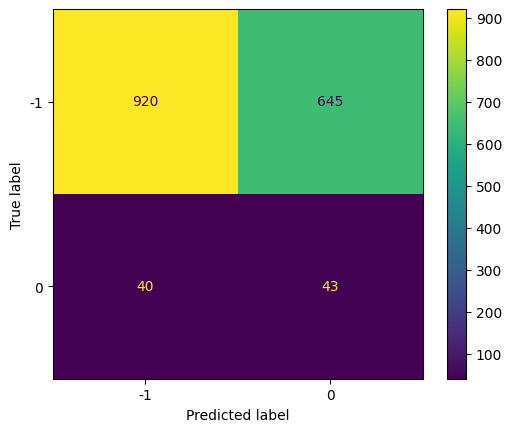

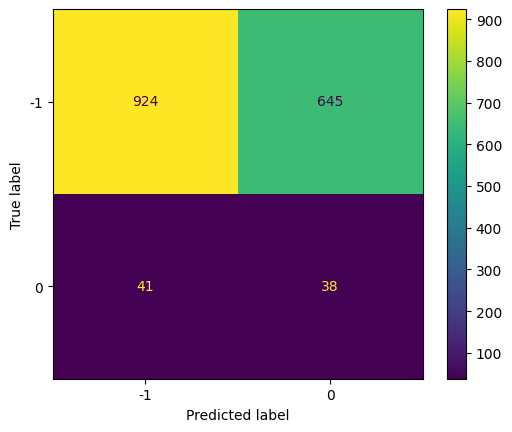

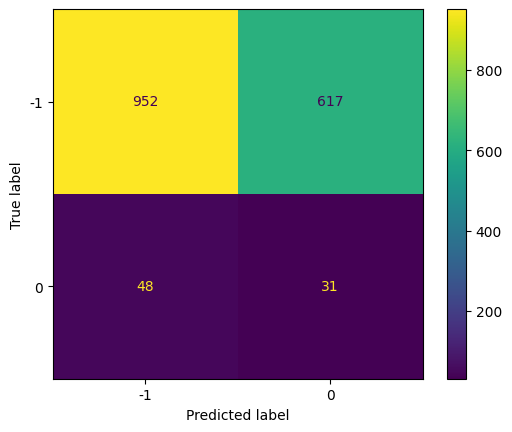

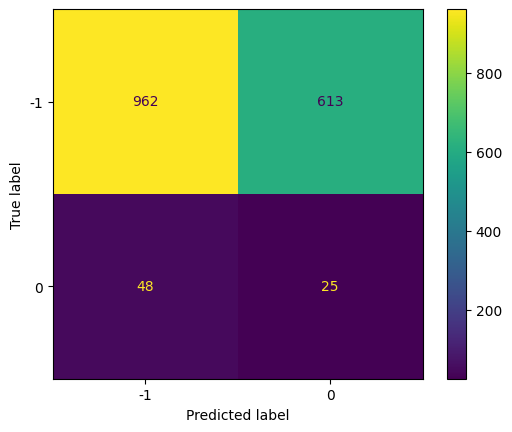

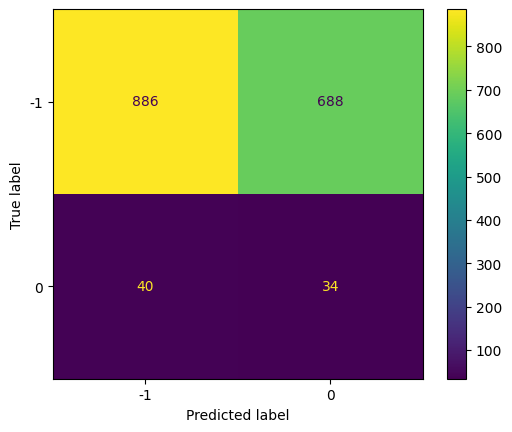

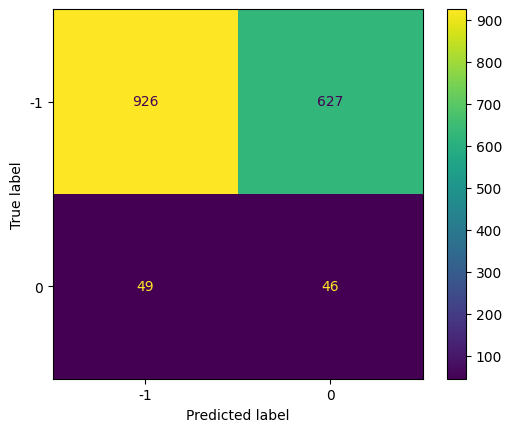

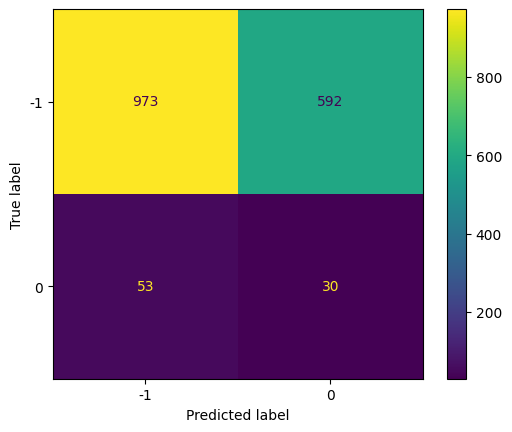

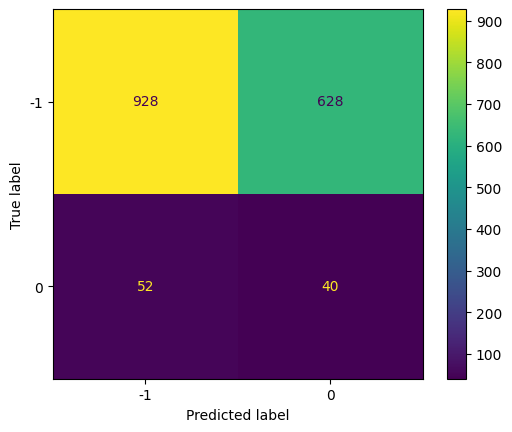

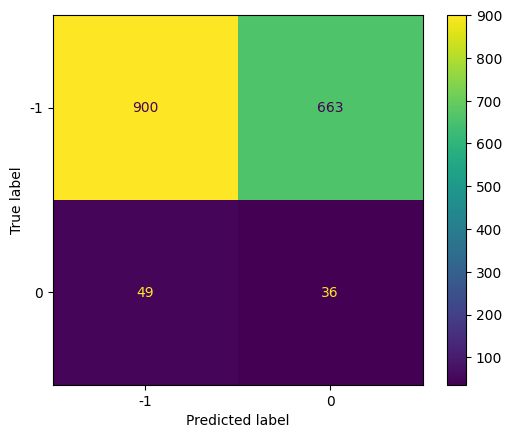

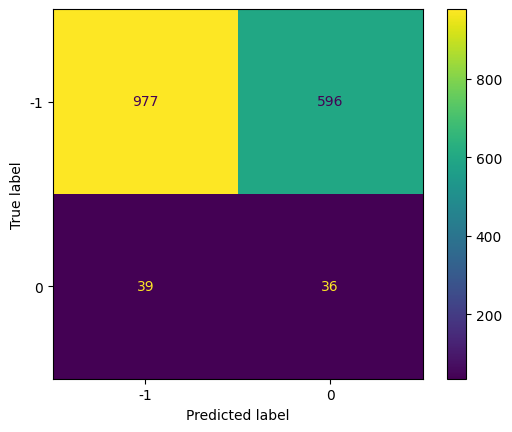

In [49]:
for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]
    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx])


    # nsamples, nx, ny = X_train.shape
    # X_train = X_train.reshape((nsamples,nx*ny))
    X_train = pca.fit_transform(X_train, y_train)
    X_test = pca.transform(X_test)

    oversample = SMOTE()
    Xs_train, ys_train = oversample.fit_resample(X_train, y_train)
    # fit classifier

    lda.fit(Xs_train, ys_train)

    y_pred = lda.predict(X_test)
    scores.append(lda.score(X_test, y_test))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)


    acc1 = accuracy_score(y_test, y_pred)
    y_pred_proba = lda.predict_proba(X_test)[:, 1]
    auc_score1 = roc_auc_score(y_test, y_pred_proba)

    # print("Accuracy: ", acc1)
    # print("AUC Score: ", auc_score1)
    accs.append(acc1)
    aucScores.append(auc_score1)
    # f11 = f1_score(y_test, y_pred)

In [50]:
accs

[0.5843446601941747,
 0.5837378640776699,
 0.5964805825242718,
 0.5989077669902912,
 0.558252427184466,
 0.5898058252427184,
 0.6086165048543689,
 0.587378640776699,
 0.5679611650485437,
 0.6146844660194175]

In [51]:
scores

[0.5843446601941747,
 0.5837378640776699,
 0.5964805825242718,
 0.5989077669902912,
 0.558252427184466,
 0.5898058252427184,
 0.6086165048543689,
 0.587378640776699,
 0.5679611650485437,
 0.6146844660194175]

# Look at performance over time



In [12]:
sfreq = 200 #raw.info["sfreq"]
print(sfreq)
w_length = int(sfreq * 0.15)  # running classifier: window length
w_step = int(sfreq * 0.03)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)
print(w_start)

200
[  0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 102
 108 114 120 126 132 138 144 150 156 162 168 174 180 186 192 198 204 210
 216 222 228 234 240 246 252 258 264 270]


200
Computing rank from data with rank=None
    Using tolerance 9.4e+03 (2.2e-16 eps * 59 dim * 7.2e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.3e+02 (2.2e-16 eps * 59 dim * 6.3e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.2e+03 (2.2e-16 eps * 59 dim * 7e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.3e+02 (2.2e-16 eps * 59 dim * 5.5e+16  max singular value

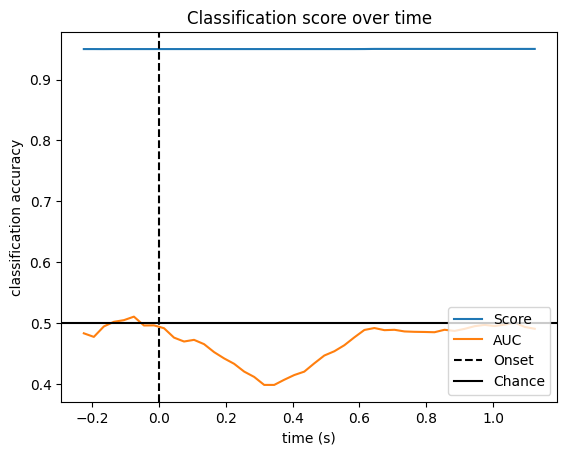

In [ ]:
sfreq = 200 #raw.info["sfreq"]
print(sfreq)
w_length = int(sfreq * 0.15)  # running classifier: window length
w_step = int(sfreq * 0.03)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windows = []

for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx])

    # fit classifier
    lda.fit(X_train, y_train)

    # running classifier: test classifier on sliding window
    score_this_window = []
    auc_scores = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n : (n + w_length)])
        score_this_window.append(lda.score(X_test, y_test))

        y_pred_proba = lda.predict_proba(X_test)[:, 1]
        auc_scores.append(roc_auc_score(y_test, y_pred_proba))

        scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.0) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label="Score")
plt.plot(w_times, auc_scores, label="AUC")
plt.axvline(0, linestyle="--", color="k", label="Onset")
plt.axhline(0.5, linestyle="-", color="k", label="Chance")
plt.xlabel("time (s)")
plt.ylabel("classification accuracy")
plt.title("Classification score over time")
plt.legend(loc="lower right")
plt.show()

Computing rank from data with rank=None
    Using tolerance 1.1e+04 (2.2e-16 eps * 59 dim * 8.3e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.1e+02 (2.2e-16 eps * 59 dim * 6.9e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e+04 (2.2e-16 eps * 59 dim * 8.8e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.3e+02 (2.2e-16 eps * 59 dim * 7.1e+16  max singular value)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Text(0, 0.5, 'True label'), Text(0.5, 0, 'Predicted label')]

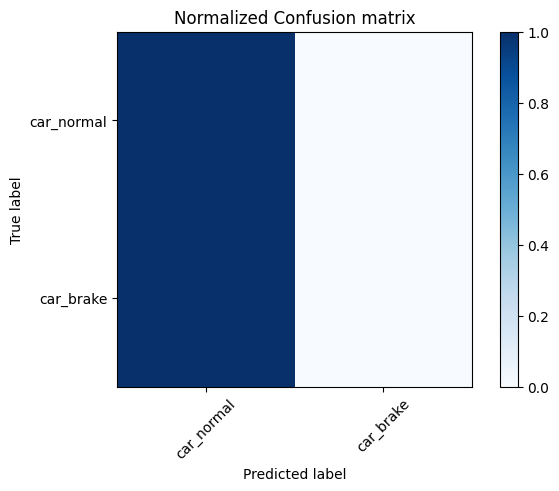

In [ ]:
# Get the labels
labels = epochs["car_normal", "car_brake"].events[:, -1]

# Cross validator
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Do cross-validation
preds = np.empty(len(labels))
for train, test in cv.split(epochs["car_normal", "car_brake"], labels):
    clf.fit(epochs[train].get_data(), labels[train])
    preds[test] = clf.predict(epochs[test].get_data())

# Classification report
target_names = ['car_normal', 'car_brake']#, 'car_hold', 'car_collision', 'react_emg']
report = classification_report(labels, preds, target_names=target_names)
print(report)

# Normalized confusion matrix
cm = confusion_matrix(labels, preds)
cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
fig, ax = plt.subplots(1, layout="constrained")
im = ax.imshow(cm_normalized, interpolation="nearest", cmap=plt.cm.Blues)
ax.set(title="Normalized Confusion matrix")
fig.colorbar(im)
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)
ax.set(ylabel="True label", xlabel="Predicted label")

In [54]:
print(X_test.shape)

(1648, 4)


In [56]:
import time
import random

start = time.time()
randomIndex = random.randint(0, len(X_test) - 1)

sampleInput = X_test[randomIndex].reshape(1,-1)
lda.predict(sampleInput)
end = time.time()
print('Time taken: ', end-start)

Time taken:  0.0009534358978271484
